# Sieci splotowe (Convolutional Neural Networks)

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

### Przygotowanie danych
Wykorzystamy w zadaniu zbiór Fashion-MNIST. Jak zwykle zaczynamy od pobrania danych, sprawdzamy krótko jak wyglądają, a następnie definiujemy miarę trafności

In [2]:
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST

target_directory = "fmnist"

fmnist_real_train = FashionMNIST(target_directory, train=True, download=True, transform=transforms.ToTensor())
fmnist_test = FashionMNIST(target_directory, train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [3]:
fmnist_train, fmnist_validation = data.random_split(fmnist_real_train, (48000, 12000))
len(fmnist_train), len(fmnist_validation)

(48000, 12000)

In [4]:
fmnist_train[0][0].shape

torch.Size([1, 28, 28])

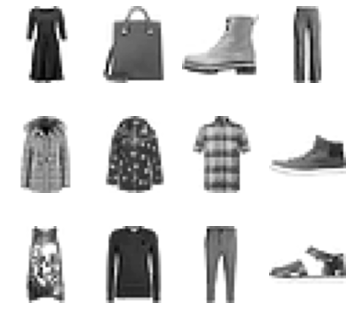

In [5]:
trainloader = data.DataLoader(fmnist_train, batch_size=64, shuffle=True)
dataiter = iter(trainloader)
images,_ = dataiter.next()
plt.figure(figsize=(5,5))
for k in range(12):
    plt.subplot(3, 4, k+1)
    plt.imshow(images[k].numpy().squeeze(), cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()

#### Warstwa splotowa (konwolucyjna)

Warstwa splotowa przemieszcza jądro (ang. *kernel*) po obrazie kawałek po kawałku, oblicza wynik i zapamiętuje go w macierzy wyjściowej. Przetwarzany obrazek jest często uzupełniany o zera (ang. *padding*), ponieważ bez tego macierz wynikowa byłaby mniejsza niż obrazek wejściowy. Piksel w macierzy wyjściowej obliczany jest następująco: każdy z pikseli obrazu wejściowego jest mnożony przez odpowiadającą mu wartość w filtrze, a tak uzyskane 9 wartości jest sumowane. Następnie ten sam filtr wykorzystywany jest do obliczenia kolejnego piksela. Filtr składa się z wag splotowej sieci neuronowej, co oznacza, że to on podlega uczeniu.

Jądro nie musi przesuwać się za każdym razem o 1 piksel, może mieć większy krok (ang. *stride*).

Jeśli obrazek jest kolorowy możemy go postrzegać jako kilka obrazków monochromatycznych.

Przykład: [jak działa sieć konwolucyjna](https://bfirst.tech/wp-content/uploads/2019/06/sieci_konwolucyjne_gif-1.gif)

Warstwę splotową w PyTorch realizuje klasa [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#torch.nn.Conv2d). Pierwsze jej trzy parametry są obowiązkowe, są to:

- liczba map na wejściu, 
- liczba map na wyjściu, 
- rozmiar jądra (jedna liczba jeżeli ma być kwadratowe albo para liczb jeżeli ma być prostokątem).

Będziemy budowali krok po kroku listę, w której będziemy umieszczali kolejne warstwy sieci.

Rozpoczniemy od dodania warstwy splotowej.

Obrazki MNIST są monochromatyczne, więc mamy tylko 1 kanał wejściowy.

Przyjmimy, że na wyjściu będziemy mieli **5 map**, każdą na bazie kwadratowego filtra o boku 3.
Żeby nie zmniejszyć zbyt szybko obrazka dodamy po 1 pikselu paddingu z każdej strony - jak w ww. przykładzie.

In [7]:
layers = [nn.Conv2d(1, 5, 3, padding=1)]

Warstwa splotowa - podobnie jak warstwa liniowa (`nn.Linear`) - jest tylko sumą. By wprowadzić nieliniowość, zastosujemy *Leaky ReLU*

In [8]:
layers.append(nn.LeakyReLU())

Druga warstwa jest nazywana łączącą (ang. *pooling layer*). Jej zadaniem jest zmniejszenie wymiarów cech konwolucyjnych, wyznaczonych w poprzedniej warstwie, przy zachowaniu kluczowych szczegółów. Odpowiada również za redukcję szumu. 

Warstwa ta, podobnie jak warstwa splotowa przesuwa filtr przez obraz, ale ten filtr jest pozbawiony parametrów: służy albo do wybierania maksimum (ang. *max pooling*) albo do obliczania średniej arytmetycznej (ang. *average pooling*). Każda mapa analizowana jest oddzielnie, więc zawsze pozostajemy w dwóch wymiarach.

Kontynuacja przykładu: [jak działa pooling](https://bfirst.tech/wp-content/uploads/2019/06/sieci_konwolucyjne_2.png)

Dodamy zatem do naszej sieci neuronowej *max pooling*, realizowany za pomocą klasy `nn.MaxPool2d`, z jądrem rozmiaru $3 x 3$ i uzupełnieniem o 1 piksel z każdej strony.

In [9]:
layers.append(nn.MaxPool2d(3, padding=1))

In [10]:
layers

[Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 LeakyReLU(negative_slope=0.01),
 MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)]

**Zadanie 1a. Mamy 5 map, a jakiego rozmiaru będą one na tym etapie przetwarzania, jeżeli wejście miało mapę rozmiaru $28 x 28$, a jądro ma rozmiar 3?**

In [11]:
# [(W−K+2P)/S]+1.

# W is the input volume 
# K is the Kernel size
# P is the padding 
# S is the stride

((28-3+2*1)/3)+1

10.0

10x10x5

### Spłaszczenie i klasyfikacja

Na tym etapie każdy obiekt przetwarzany przez sieć jest trójwymiarowy, czyli składa się z pewnej liczby dwuwymiarowych map. Do klasyfikacji wykorzystamy sumującą warstwę liniową `nn.Linear`. Nie jest to dla niej odpowiedni format wejścia. Zatem najpierw za pomocą klasy `nn.Flatten` ułożymy piksele jeden za drugim w wektor.

**Zadanie 1b. Klasyfikujemy do 10 klas, więc mamy 10 neuronów wyjściowych, a ilu potrzeba wejść? Uzupełnij kod (w miejscu ...) na podstawie wyników zad. 1.**

In [12]:
layers.append(torch.nn.Flatten())
layers.append(nn.Linear(500, 10))

### Konfiguracja sieci

**Zadanie 2. Połącz gotowe warstwy w jeden sekwencyjny moduł, jako funkcję straty zadeklaruj entropię krzyżową/skrośną, a do optymalizacji parametrów modelu użyj optymalizatora Adam.**

In [13]:
model = nn.Sequential(*layers)

cost = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.1)

In [14]:
model

Sequential(
  (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=500, out_features=10, bias=True)
)

### Uczenie z wykorzystaniem wczesnego zatrzymania

Wczesne zatrzymanie (ang. *early stopping*) składa się z następujących kroków:
- co określoną liczbę epok uczenia obliczamy miarę oceny (np. trafność klasyfikacji) na zbiorze walidującym
- jeżeli nastąpiła poprawa w stosunku do poprzedniego razu, zapamiętujemy obecne wartości wag sieci neuronowej
- jeżeli przez określoną liczbę epok nie następuje poprawa, przerywamy uczenie i przywracamy wagi ostatniego najlepszego modelu

**Zadanie 3. Poniższy kawałek kodu oblicza trafność na zbiorze walidującym co epokę. Dodaj kod przerywający uczenie, jeżeli przez 5 kolejnych epok nie nastąpiła poprawa. Wyświetlaj wynik i numer porządkowy aktualnie najlepszej epoki, skorzystaj z zadeklarowanych zmiennych, podaj informację o fakcie wczesnego zatrzymania. Pamiętaj że najlepszy model powinien zostać zapisany, sprawdź w dokumentacji biblioteki pytorch jak to zrobić. Na końcu załaduj najlepszy model.**

In [15]:
train_loss = []
validation_acc = []
best_model = None
best_acc = None
best_epoch = None
max_epoch = 10000
no_improvement = 5
batch_size = 512
epoches_no_improvement =0

for n_epoch in range(max_epoch):
    model.train()
    loader = data.DataLoader(fmnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch)
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    train_loss.append(torch.tensor(epoch_loss).mean())
    model.eval()
    loader = data.DataLoader(fmnist_validation, batch_size=len(fmnist_validation), shuffle=False)
    X, y = next(iter(loader))
    logits = model(X)
    acc = compute_acc(logits, y).detach()
    validation_acc.append(acc)
    
    #tutaj napisz kod wczesnego zatrzymania

    if best_acc is None or acc > best_acc:
        best_model = model.state_dict()
        best_acc = acc
        best_epoch = n_epoch
        no_progress = 0
        print(f'Best epoch: {best_epoch}, Best acc: {best_acc}')
    else:
        epoches_no_improvement +=1
        if epoches_no_improvement >= no_improvement:
            break


    
    
model.load_state_dict(best_model)

Best epoch: 0, Best acc: 0.8607500195503235
Best epoch: 1, Best acc: 0.8686666488647461
Best epoch: 4, Best acc: 0.8690000176429749
Best epoch: 6, Best acc: 0.8714166879653931


<All keys matched successfully>

Przyjrzyj się poniższym wykresom

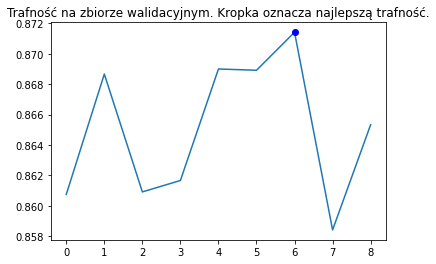

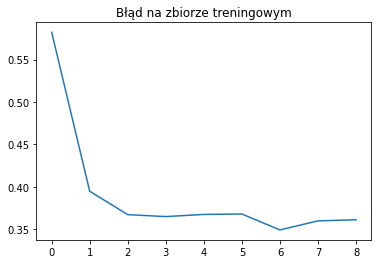

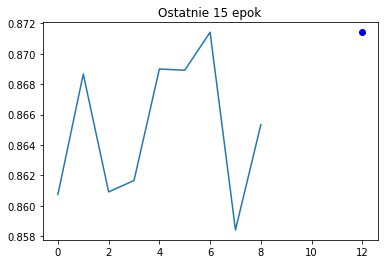

In [16]:
plt.title('Trafność na zbiorze walidacyjnym. Kropka oznacza najlepszą trafność.')
plt.plot(validation_acc, label='Trafność na zbiorze walidacyjnym')
plt.plot(best_epoch, best_acc, 'bo', label='Najlepsza trafność')
plt.show()
plt.title('Błąd na zbiorze treningowym')
plt.plot(train_loss)
plt.show()
k = max(3*no_improvement, 0)
plt.title('Ostatnie {} epok'.format(k))
plt.plot(validation_acc[-k:])
plt.plot(best_epoch-(len(validation_acc)-k), best_acc, 'bo')
plt.show()

**Zadanie 4. Dlaczego wczesne zatrzymanie jest realizowane na zbiorze walidującym, a nie na zbiorze uczącym albo na zbiorze testowym?**

Wczesne zatrzymanie jest realizowane na zbiorze walidacyjnym, ponieważ jest stosowane w celu uniknięcia overfittingu, potrzebne są dane niezależne od danych treningowych

**Zadanie 5. Przyjrzyj się jeszcze raz kodowi odpowiedzialnemu za epokę uczenia. Wykorzystaj linijki odpowiedzialne tam za obliczanie trafności i oblicz trafność klasyfikacji: na zbiorze walidującym oraz na zbiorze testowym. Czy uzyskane wartości się różnią? Co może być powodem różnic?**

In [18]:
loader

In [19]:
model.eval()

#tutaj trafność na zbiorze walidacyjnym
loader_val = data.DataLoader(fmnist_validation, batch_size=len(fmnist_test), shuffle=False)
X_val, y_val = next(iter(loader_val))
y_val_pred = model(X_val)
acc_val = compute_acc(y_val_pred, y_val)
print("Dokladnosc na zbiorze walidacyjnym", acc_val)

#tutaj trafność na zbiorze testowym
loader_test = data.DataLoader(fmnist_test, batch_size=len(fmnist_test), shuffle=False)
X_test, y_test = next(iter(loader_test))
y_test_pred = model(X_test)
acc_test = compute_acc(y_test_pred, y_test)
print("Dokladnosc na zbiorze testowym", acc_test)

Dokladnosc na zbiorze walidacyjnym tensor(0.8664)
Dokladnosc na zbiorze testowym tensor(0.8593)


In [20]:
y_test_pred.shape

torch.Size([10000, 10])

In [22]:
y_val_pred.shape

torch.Size([10000, 10])

Uzyskane wartosći nieznaczne się róznią, róznice mogą wynikać z przeuczenia lub różnorodności danych
